In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex
import seaborn as sns
from sklearn import set_config
set_config(display='diagram')

%matplotlib inline

#### Prepare the data

In [2]:
# Read the data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Standarize data formats
df.columns = df.columns.str.lower().str.replace(' ','_')
categCols = df.select_dtypes('object').columns.to_list()
for col in categCols:
    df[col] = df[col].str.lower().str.replace(' ','_')
    
# Correct values and type of variable totalcharges
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')

# Filling missing values with zero
df.totalcharges.fillna(0, inplace=True)

# Make seniorcitizen an object type variable
df.seniorcitizen = df.seniorcitizen.astype(bool).astype(object)

# Converting the target variable to binary values, no=0 or yes=1.
df.churn = (df.churn == 'yes').astype(int)
df.churn.head()

df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,False,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,False,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,False,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,False,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,False,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


#### Data processing and model

In [3]:
targetCol = 'churn'
target = df[targetCol]
data = df.drop(columns=[targetCol])

In [4]:
# Getting numerical and categorical columns
from sklearn.compose import make_column_selector as selector
numColSelector = selector(dtype_exclude=object)
ctgColSelector = selector(dtype_include=object)
numericalCols = numColSelector(data)
categoricalCols = ctgColSelector(data)
categoricalCols.remove('customerid')

# creating preprocesors
from sklearn.preprocessing import OneHotEncoder, StandardScaler
catPreprocessor = OneHotEncoder(handle_unknown="ignore")
numPreprocessor = StandardScaler()

# Transforming the data
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    ('one-hot-encoder', catPreprocessor, categoricalCols)],remainder="passthrough")
    #('one-hot-encoder', catPreprocessor, categoricalCols),
    #('standard_scaler', numPreprocessor, numericalCols)])
    
# creating the model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))    

# Splitting the data
from sklearn.model_selection import train_test_split
allColumns = numericalCols + categoricalCols
dataTrainFull, dataTest, targetTrainFull, targetTest = train_test_split(
    data[allColumns], target, test_size=0.2, random_state=1)
dataTrain, dataVal, targetTrain, targetVal = train_test_split(
    dataTrainFull, targetTrainFull, test_size=0.25, random_state=1)
#print(len(dataTrain), len(dataVal), len(dataTest))

In [5]:
_ = model.fit(dataTrain, targetTrain)
acc = round(model.score(dataVal, targetVal),3)
print(f'Accuracy of base model: {acc}')

Accuracy of base model: 0.803


In [6]:
valPred = model.predict_proba(dataVal)[:,1]
valPred

array([0.00775403, 0.2055377 , 0.22004259, ..., 0.14923791, 0.7831508 ,
       0.81251385])

In [7]:
from sklearn.metrics import accuracy_score
binaryPred = model.predict(dataVal)
accuracy_score(targetVal, binaryPred)

0.8034066713981547

In [8]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churnPred = (valPred >= t)
    score = (targetVal == churnPred).mean()
    print(f'Threshold: {t:.2f}, Score: {score:.4f}')
    scores.append(score)

Threshold: 0.00, Score: 0.2740
Threshold: 0.05, Score: 0.5082
Threshold: 0.10, Score: 0.6011
Threshold: 0.15, Score: 0.6636
Threshold: 0.20, Score: 0.7069
Threshold: 0.25, Score: 0.7388
Threshold: 0.30, Score: 0.7601
Threshold: 0.35, Score: 0.7665
Threshold: 0.40, Score: 0.7828
Threshold: 0.45, Score: 0.7942
Threshold: 0.50, Score: 0.8034
Threshold: 0.55, Score: 0.8020
Threshold: 0.60, Score: 0.7977
Threshold: 0.65, Score: 0.7864
Threshold: 0.70, Score: 0.7658
Threshold: 0.75, Score: 0.7431
Threshold: 0.80, Score: 0.7289
Threshold: 0.85, Score: 0.7260
Threshold: 0.90, Score: 0.7260
Threshold: 0.95, Score: 0.7260
Threshold: 1.00, Score: 0.7260


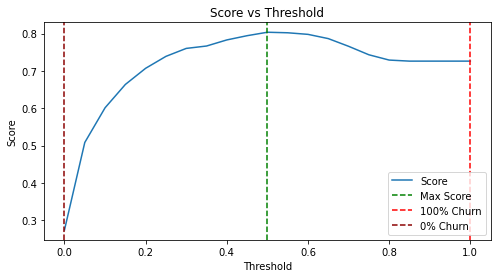

In [9]:
font = {'family': 'serif',
        'color':  'blue',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(thresholds, scores, label='Score')  # Plot some data on the axes.
ax.set_xlabel('Threshold')  # Add an x-label to the axes.
ax.set_ylabel('Score')  # Add a y-label to the axes.
ax.set_title("Score vs Threshold")  # Add a title to the axes.
plt.axvline(x=0.5, linestyle='dashed', color='green', label='Max Score')
plt.axvline(x=1.0, linestyle='dashed', color='red', label='100% Churn')
plt.axvline(x=0, linestyle='dashed', color='darkred', label='0% Churn')

ax.legend();  # Add a legend.
_ = plt.show()

In [10]:
from collections import Counter
count = Counter(targetVal)
for i,j in count.items():
    print(f'target: {i}, count: {j}')
print(f'Target 0 has almost 3 times as much samples as target 1 Total t0/t1 = {round(count[0]/count[1],2)}')
print(f'Total mean of targetVal data is the same as the predicted by dummy predictor'
      f'(when threshold == 1) = {1 - targetVal.mean()}')

target: 0, count: 1023
target: 1, count: 386
Target 0 has almost 3 times as much samples as target 1 Total t0/t1 = 2.65
Total mean of targetVal data is the same as the predicted by dummy predictor(when threshold == 1) = 0.7260468417317246


There is class imbalace in the target values. It's almost 3 to 1. So accuracy here is not a good measure.

#### Confusion table

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

targetValPred = model.predict(dataVal)

920 103 174 212


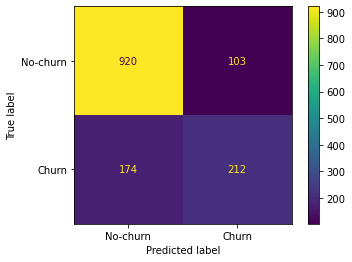

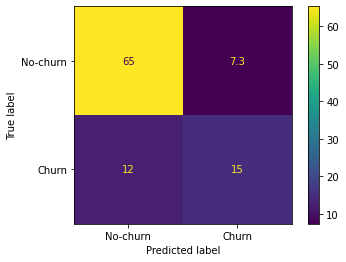

In [21]:
cm = confusion_matrix(targetVal, targetValPred)
cmprob = np.round(100 * cm / len(targetVal), 1)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['No-churn', 'Churn']).plot()
cm_display = ConfusionMatrixDisplay(cmprob, display_labels=['No-churn', 'Churn']).plot()
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)

In [22]:
# Another way

threshold = 0.5

actualPos = targetVal == 1
actualNeg = targetVal == 0
predictPos = targetValPred >= threshold
predictNeg = targetValPred < threshold

tp = (actualPos & predictPos).sum()
fp = (predictPos & actualNeg).sum()
tn = (actualNeg & predictNeg).sum()
fn = (actualPos & predictNeg).sum()

confMatrix = np.array([[tn, fp],[fn, tp]])
display('Confusion matrix:', confMatrix)
display('Percentages:', (confMatrix/confMatrix.sum()).round(2))

'Confusion matrix:'

array([[920, 103],
       [174, 212]], dtype=int64)

'Percentages:'

array([[0.65, 0.07],
       [0.12, 0.15]])

In [30]:
targetValPred2 = (model.predict_proba(dataVal)[0:,1] > 0.5) * 1
print((targetValPred2 == targetValPred).sum())

1409


#### Precision and Recall

In [31]:
# Precision: calculates the part of the predictions that was correct p = tp / (fp + tp)

p = tp / (fp + tp)
print(round(p,2))

0.67


In [32]:
# Recall: calculates the part of the actual values that was predicted correct r = tp / (tp + fn)

r = tp / (tp + fn)
print(round(r,2))

0.55


In [33]:
# Another way, with sklearn
print(classification_report(targetVal, targetValPred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1023
           1       0.67      0.55      0.60       386

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.79      0.80      0.80      1409



#### ROC Curves

In [34]:
tpr = tp / (tp + fn)
tpr

0.5492227979274611

In [35]:
fpr = fp / (fp + tn)
fpr

0.10068426197458455

In [39]:
thresholds = np.linspace(0, 1, 101)

scores = []
targetValPredProba = model.predict_proba(dataVal)[0:,1]

for t in thresholds:
    actualPos = (targetVal == 1)
    actualNeg = (targetVal == 0)
    predictPos = (targetValPredProba >= t)
    predictNeg = (targetValPredProba < t)

    tp = (actualPos & predictPos).sum()
    tn = (actualNeg & predictNeg).sum()
    
    fp = (predictPos & actualNeg).sum()
    fn = (actualPos & predictNeg).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [43]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
dfScores = pd.DataFrame(scores, columns=columns)

In [46]:
dfScores['tpr'] = dfScores.tp / (dfScores.tp + dfScores.fn)
dfScores['fpr'] = dfScores.fp / (dfScores.fp + dfScores.tn)

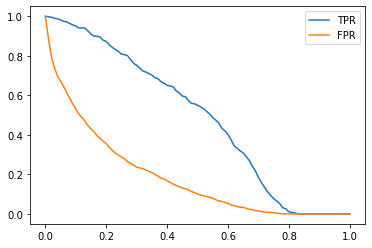

In [49]:
plt.plot(dfScores.threshold, dfScores.tpr, label='TPR')
plt.plot(dfScores.threshold, dfScores.fpr, label='FPR')
plt.legend()
_ = plt.show()